# Case Study: Unusual Deaths in Mexico

> The following case study illustrates how tidy data and tidy tools make data analysis easier by easing the transitions between manipulation, visualisation and modelling. You will not see any code that exists solely to get the output of one function into the right format to input to another.

> The case study uses individual-level mortality data from Mexico. The goal is to find causes of death with unusual temporal patterns within a day.

## "Housekeeping"

In [1]:
% load_ext watermark
% watermark -d -t -v -z -p matplotlib,numpy,pandas,seaborn

2018-08-27 11:47:22 CEST

CPython 3.6.5
IPython 6.5.0

matplotlib 2.2.3
numpy 1.15.1
pandas 0.23.4
seaborn 0.9.0


In [2]:
import math
import textwrap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
import rpy2.robjects.pandas2ri as pandas2ri
import seaborn as sns

from sklearn.linear_model import HuberRegressor

In [3]:
% matplotlib inline

In [4]:
sns.set()

## Load the Data

In [5]:
deaths = pandas2ri.ri2py(robjects.r['readRDS']('data/deaths.rds'))
deaths = deaths[(deaths['yod'] == 2008) & (deaths['mod'] != 0)
                & (deaths['dod'] != 0)]
#deaths.loc[(deaths['hod'] < 0), 'hod'] = 0
deaths = deaths[~(deaths['hod'] < 0)]
deaths = deaths.reset_index(drop=True)
assert set(deaths['hod'].unique()) <= set(range(24))

In [6]:
deaths.shape

(502520, 5)

In [7]:
deaths.head()

,yod,mod,dod,hod,cod
0,2008,1,1,1,B20
1,2008,1,1,1,B22
2,2008,1,1,1,C18
3,2008,1,1,1,C34
4,2008,1,1,1,C50


In [8]:
# Note that this file contains 7 duplicates that are removed.
codes = pd.read_csv('data/icd-main.csv')
codes = codes[(codes['code'] != codes['code'].shift())].set_index('code')

In [9]:
codes.shape

(1851, 1)

In [10]:
codes.head()

,disease
code,
A00,Cholera
A01,Typhoid and paratyphoid fevers
A02,Other salmonella infections
A03,Shigellosis
A04,Other bacterial intestinal infections


## Counts

Count the number of deaths by *hour of the day* and *cause of death* (and also join in the more descriptive labels for the various causes).

In [11]:
counts = (
    pd.DataFrame(deaths.groupby(['hod', 'cod']).size(), columns=['freq'])
    .reset_index()
    .join(codes, on='cod')
)
# This is to ensure that no duplicates are created
# because of duplicate entries in the codes DataFrame.
assert counts['cod'].value_counts().max() <= 24

# Keep only causes where a death happened in every hour.
counts = counts[counts['cod'].isin(list((counts['cod'].value_counts() == 24).index))]

counts.head()

,hod,cod,freq,disease
0,1,A01,3,Typhoid and paratyphoid fevers
1,1,A02,3,Other salmonella infections
2,1,A04,7,Other bacterial intestinal infections
3,1,A05,1,"Other bacterial foodborne intoxications, not e..."
4,1,A06,2,Amebiasis


Add a *prop* column indicating the relative frequency of a given *cause of death* on an hourly basis.

In [12]:
counts = counts.set_index('cod')
counts['prop'] = (
    counts['freq']
    / deaths.groupby(['cod']).size().reindex(counts.index)
)
counts = counts.reset_index()
# Re-order the columns as in the paper.
counts = counts[['hod', 'cod', 'freq', 'disease', 'prop']]

counts.head()

,hod,cod,freq,disease,prop
0,1,A01,3,Typhoid and paratyphoid fevers,0.062500
1,1,A02,3,Other salmonella infections,0.048387
2,1,A04,7,Other bacterial intestinal infections,0.051095
3,1,A05,1,"Other bacterial foodborne intoxications, not e...",0.050000
4,1,A06,2,Amebiasis,0.024390


Add *freq_all* and *prop_all* columns that show the absolute number of deaths for a given *hour of day* (disregarding *cause of death*) and the proportion of deaths for a certain *hour of day* with respect to the whole day.

In [13]:
counts = counts.set_index('hod')
counts['freq_all'] = deaths.groupby('hod').size()
counts['prop_all'] = counts['freq_all'] / deaths.shape[0]
counts = counts.reset_index()

counts.head()

,hod,cod,freq,disease,prop,freq_all,prop_all
0,1,A01,3,Typhoid and paratyphoid fevers,0.062500,20038,0.039875
1,1,A02,3,Other salmonella infections,0.048387,20038,0.039875
2,1,A04,7,Other bacterial intestinal infections,0.051095,20038,0.039875
3,1,A05,1,"Other bacterial foodborne intoxications, not e...",0.050000,20038,0.039875
4,1,A06,2,Amebiasis,0.024390,20038,0.039875


## Distance between temporal Patterns

> Next we compute a distance between the temporal pattern of each cause of death and the overall temporal pattern. There are many ways to measure this distance, but I found a simple mean squared deviation to be revealing. We also record the sample size, the total number of deaths from that cause. To ensure that the diseases we consider are sufficiently representative we’ll only work with diseases with more than 50 total deaths (∼2/hour).

In [14]:
devi = (
    codes
    .join(
        deaths.groupby('cod')
        .count()['yod']
        .to_frame(),
        how='inner',
    )
    .join(
        counts.groupby('cod')
        .apply(lambda x: ((x['prop'] - x['prop_all']) ** 2).mean())
        .to_frame(),
        how='inner',
    )
    .rename(columns={'yod': 'n', 0: 'dist'})
)
devi = devi[(devi['n'] > 50)]

devi.head()

,disease,n,dist
A02,Other salmonella infections,62,0.000738
A04,Other bacterial intestinal infections,137,0.000208
A06,Amebiasis,82,0.000405
A09,Diarrhea and gastroenteritis of infectious origin,3016,0.000028
A16,"Respiratory tuberculosis, not confirmed bacter...",1642,0.000029


Plot *dist* vs. *n*. Not a whole lot can be seen here.

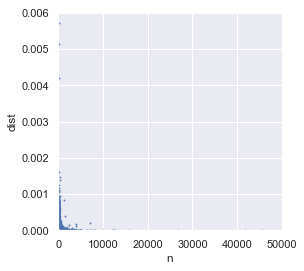

In [15]:
_, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 50000)
ax.set_ylim(0, 0.006)
sns.regplot(
    x='n', y='dist', data=devi, ax=ax, fit_reg=False, scatter_kws={'s': 1}
);

The relationship becomes more obvious if one plots the same points on a log-log scale.

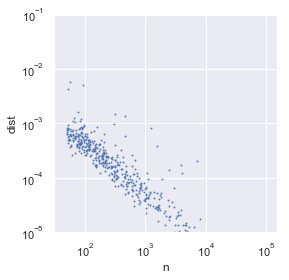

In [16]:
_, ax = plt.subplots(figsize=(4, 4))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(30, 150000)
ax.set_ylim(0.00001, 0.1)
sns.regplot(
    'n', 'dist', data=devi, ax=ax, fit_reg=False, scatter_kws={'s': 1}
);

> We are interested in points that have high y-values, relative to their x-neighbours. Controlling for the number of deaths, these points represent the diseases which depart the most from the overall pattern. To find these unusual points, we fit a robust linear model and plot the residuals, Figure 3. The plot shows an empty region around a residual of 1.5. So somewhat arbitrarily, we’ll select those diseases with a residual greater than 1.5.

In [17]:
# Note that the HuberRegressor is not the exact
# same method as in the paper but close.
X = np.log(devi['n']).values[:, np.newaxis]
y = np.log(devi['dist']).values
rlm = HuberRegressor()
rlm.fit(X, y)
devi['residuals'] = y - rlm.predict(X)

Plot the threshold for "unusual" deaths, set arbitrarily at 1.5.

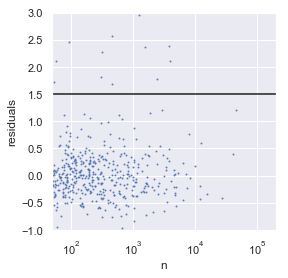

In [18]:
_, ax = plt.subplots(figsize=(4, 4))
ax.set_xscale('log')
ax.set_xlim(50, 200000)
ax.set_ylim(-1, 3)
sns.regplot(
    'n', 'residuals', data=devi, ax=ax, fit_reg=False, scatter_kws={'s': 1}
)
ax.hlines(1.5, 0, 200000);

> Finally, we plot the temporal course for each unusual cause, Figure 4. We split the diseases into two plots because of differences in variability. The top plot shows diseases with over 350 deaths and the bottom with under 350. The causes of death fall into three main groups: murder, drowning, and transportation related. Murder is more common at night, drowning in the afternoon, and transportation related deaths during commute times. The pale gray line in the background shows the temporal course across all diseases.

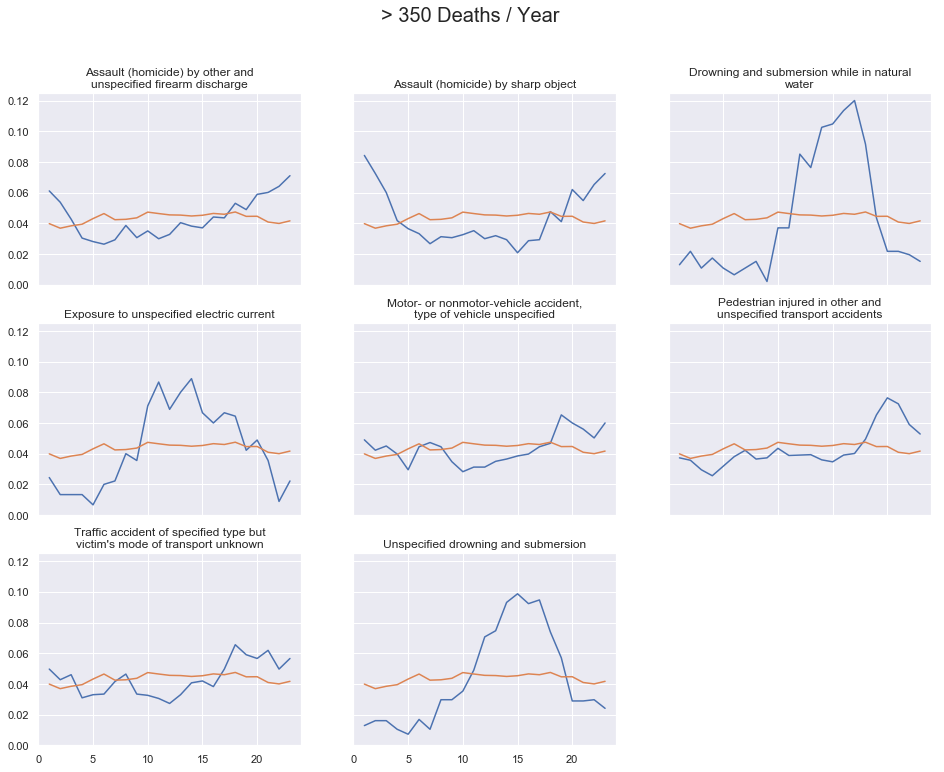

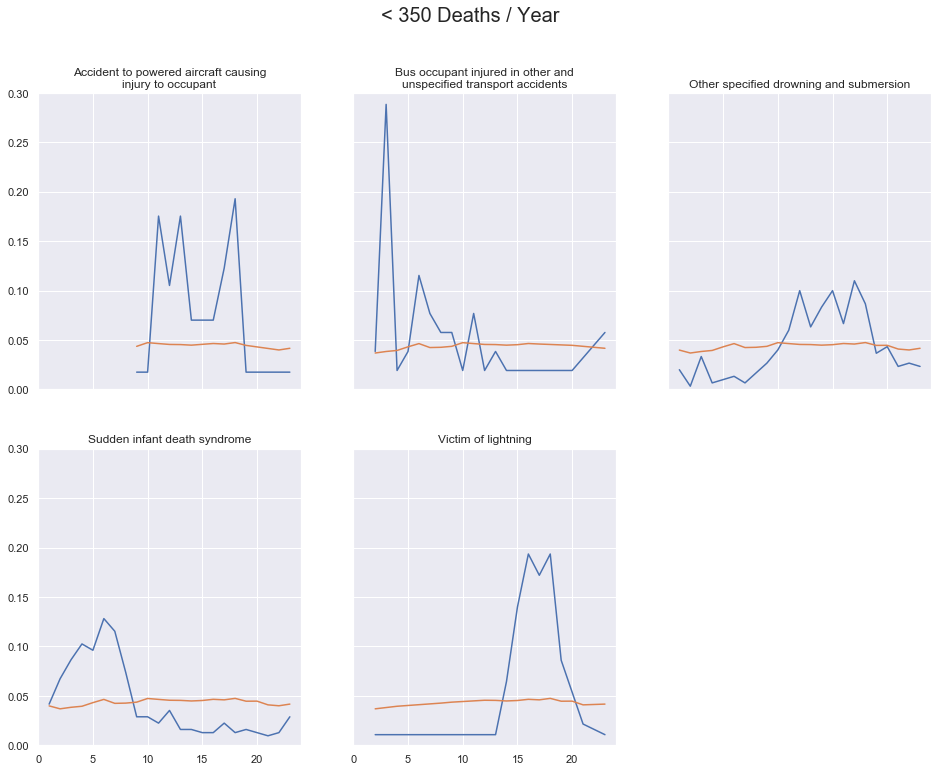

In [19]:
# Get all temporarily "unusual" deaths.
unusual = (
    devi.loc[(devi['residuals'] > 1.5), ['disease', 'n']]
    .sort_values('disease')
)
# Helper dataset for easy indexing / value retrieval.
plot_data = counts[['cod', 'hod', 'prop', 'prop_all']].set_index('cod')
# Divide the plots in two big categories.
for header, cond, ylim in [
    ('> 350 Deaths / Year', (unusual['n'] > 350), 0.125),
    ('< 350 Deaths / Year', (unusual['n'] <= 350), 0.3),
]:
    nrows = math.ceil(len(unusual[cond]) / 3)
    fig = plt.figure(figsize=(16, 12), )
    for i, (cod, (disease, _)) in enumerate(unusual[cond].iterrows(), 1):
        ax = fig.add_subplot(nrows, 3, i)
        ax.set_title('\n'.join(textwrap.wrap(disease, 40)))
        ax.set_xlim(0, 24)
        ax.set_ylim(0, ylim)
        ax.plot(plot_data.loc[cod, 'hod'], plot_data.loc[cod, 'prop'])
        ax.plot(plot_data.loc[cod, 'hod'], plot_data.loc[cod, 'prop_all'])
        # Show only lower and left axes.
        if i not in (3 * nrows - 2, 3 * nrows - 1, 3 * nrows):
            plt.setp(ax.get_xticklabels(), visible=False)
        if i % 3 != 1:
            plt.setp(ax.get_yticklabels(), visible=False)
    fig.suptitle(header, fontsize=20)